In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle, os

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

C:\Users\atami\anaconda3\envs\jcopml\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
df = pd.read_csv("data/taxi_fare.csv", parse_dates=["pickup_datetime"])
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


In [5]:
df.isna().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      1
dtype: int64

In [7]:
df.shape

(18919, 7)

In [8]:
df.dropna(inplace=True)

### Extract Date -Time

In [9]:
pickup_dt = df.pickup_datetime.dt

In [10]:
df['year'] = pickup_dt.year
df['month'] = pickup_dt.month
df['day'] = pickup_dt.day
df['hour'] = pickup_dt.hour
df.drop(columns="pickup_datetime", inplace=True)
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,15,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,5,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,18,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,21,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,9,7


## Extract Distance Feature

In [14]:
df['distance'] = np.abs(df.pickup_longitude - df.dropoff_longitude) + np.abs(df.pickup_latitude - df.dropoff_latitude)
df.drop(columns=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], inplace=True)
df.head()

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,15,17,0.011742
1,16.9,1.0,2010,1,5,16,0.107481
2,5.7,2.0,2011,8,18,0,0.019212
3,7.7,1.0,2012,4,21,4,0.029386
4,5.3,1.0,2010,3,9,7,0.027194


## Dataset Splitting

In [15]:
X = df.drop(columns="fare_amount")
y = df.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15134, 6), (3784, 6), (15134,), (3784,))

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp


preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ["passenger_count", "year", "distance"]),
    ('categoric', cat_pipe(encoder='onehot'), ["month", "day", "hour"]),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])


parameter = {
    'prep__numeric__poly__degree': [1, 2, 3],
    'prep__numeric__poly__interaction_only': [True, False],
    'algo__fit_intercept': [True, False]
}


model = GridSearchCV(pipeline, gsp.linreg_poly_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'algo__fit_intercept': True, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': True}
0.014286661621076613 0.014745076048168992 0.009910317549035375


## Feature Importance

### The model is bad, don't do that

## Actual vs Prediction

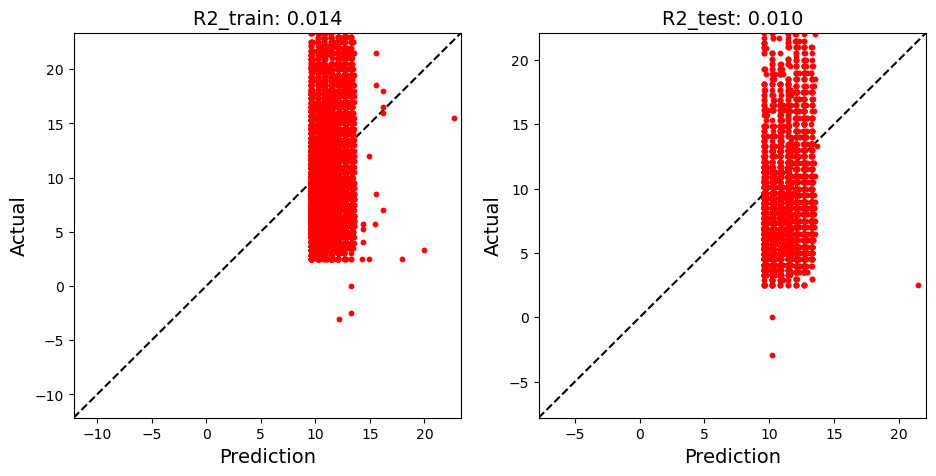

In [27]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual

plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)

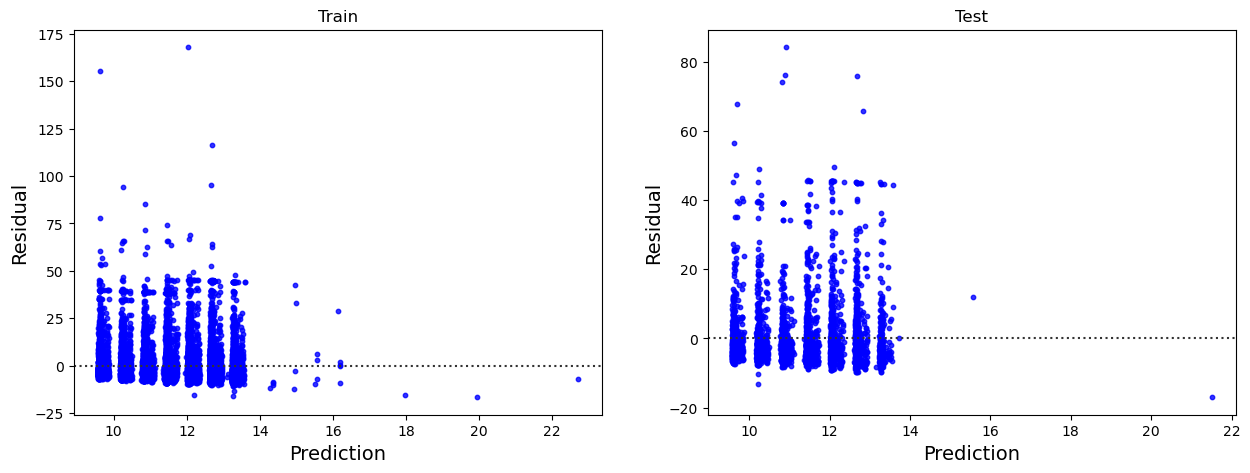

In [25]:
plot_residual(X_train, y_train, X_test, y_test, model)

## Unbalance data => Transform

In [28]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, transform='yeo-johnson'), ["passenger_count", "year", "distance"]),
    ('categoric', cat_pipe(encoder='onehot'), ["month", "day", "hour"]),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])


parameter = {
    'prep__numeric__poly__degree': [1, 2, 3],
    'prep__numeric__poly__interaction_only': [True, False],
    'algo__fit_intercept': [True, False]
}


model = GridSearchCV(pipeline, gsp.linreg_poly_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\atami\anaconda3\envs\jcopml\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__fit_intercept': True, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.7193370612961523 0.7145519945342992 0.745081064455932


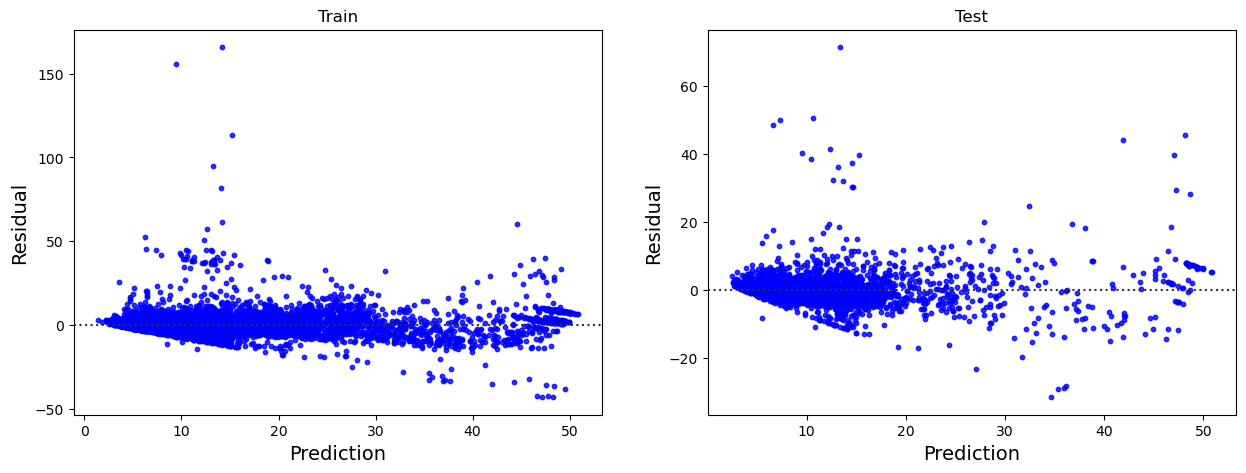

In [29]:
plot_residual(X_train, y_train, X_test, y_test, model)